# 03. Gibbs Sampler for Factorization Machine

$\DeclareMathOperator*{\argmin}{arg~min}$

In [1]:
import numpy as np
from typing import Optional

## From ALS to Gibbs Sampler

Results of ordinary least squares are equivalent to the maximum a posteriori (MAP) estimation of a linear regression model with normally distributed errors.

That is, when the likelihood of $\theta$ is given by

$$
\begin{aligned}
p(y^{(d)} | \theta, x^{(d)}) &= \mathcal{N}(y^{(d)} | \theta x^{(d)}, \sigma_n^2),
\end{aligned}
$$

where $\sigma_n^2$ is the variance of the noise and its prior is uniform, the posterior distribution of $\theta$ is given by

$$
\begin{aligned}
p(\theta | y, x)
&\propto
p(y | \theta, x) p(\theta)
\\

&\propto
\prod_{d=1}^D \mathcal{N}(y^{(d)} | \theta x^{(d)}, \sigma_n^2) \times 1
\\

&\propto
\exp\left(-\frac{1}{2\sigma_n^2} \sum_{d=1}^D (y^{(d)} - \theta x^{(d)})^2\right)
\\

&=
\exp\left(-\frac{1}{2\sigma_n^2} \sum_{d=1}^D x^{(d)2} \left( \theta - \left( \sum_{d=1}^D x^{(d)2} \right)^{-1} \sum_{d=1}^D x^{(d)}y^{(d)} \right)^2 \right)
\\

&\propto
\mathcal{N}\left(\theta \middle| \mu_\theta^\star, \sigma_\theta^{\star 2} \right),
\end{aligned}
$$

where

$$
\begin{aligned}
\mu_\theta^\star
&=
\left( \sum_{d=1}^D x^{(d)2} \right)^{-1} \sum_{d=1}^D x^{(d)}y^{(d)},
\\

\sigma_\theta^{\star 2}
&=
\sigma_n^2 \left( \sum_{d=1}^D x^{(d)2} \right)^{-1}.
\end{aligned}
$$

Obviously, its MAP estimation, a.k.a. maximum likelihood estimation (MLE) --since it is equivalent to maximizing the likelihood function--,

$$
\hat \theta = \mu_\theta^\star
$$

is equivalent to the ordinary least squares solution.

In the similar way, the L2 regularized least squares is equivalent to the MAP estimation of a linear regression model with

- normal likelihood $p(y^{(d)} | \theta, x^{(d)}) \sim \mathcal{N}(y^{(d)} | \theta x^{(d)}, \sigma_n^2)$ and
- a Gaussian prior $\theta \sim \mathcal N(\theta | \mu_\theta, \sigma_\theta^2)$.

What then about sampling from the posterior distribution instead of performing MAP estimation for each parameter $\theta$ at each iteration in the ALS?

In this case, we are drawing samples from the posterior distribution of $\theta$ given $x, y$ and the other parameters $\Theta \setminus \{ \theta \}$, that is,

$$
\begin{aligned}
\tilde \theta | x, y, \Theta \setminus \{ \theta \} \sim p(\theta | x, y, \Theta \setminus \{ \theta \}) \quad \forall \theta \in \Theta.
\end{aligned}
$$

As can be seen from its expression, this posterior sampling operation is equivalent to performing **Gibbs sampling**, a type of MCMC method.

## Factorization Machine as Hierarchical Bayesian Model

Following [Rendle+ (2012)], we build a hierarchical Bayesian model for FM, which is known as the **Bayesian factorization machine** (BFM).

The hiearchical expression of the BFM is given by the graphical model below.

![alt text](figures/FM_03_hierarchical.svg)

Here,

- $\mathcal D = \{ (x^{(d)}, y^{(d)}) \}_{d=1, \dots, D}$ (denoted by $x, y$) is the dataset,
- $\Theta_M = \{ b, w, v, \sigma_n^2 \}$ are model parameters,
- $\Theta_H = \{ \mu_\theta, \sigma_\theta^2, \sigma_n^2 \}$ are latent parameters, and
- $\Theta_F = \{ \mu_b, \sigma_b^2, m_\theta, \lambda_\theta, a_\theta, b_\theta, a_n, b_n \}$ are fixed parameters.

In the following, $\Theta = \Theta_M \cup \Theta_H \cup \Theta_F$ is used to simplify the notation.

We assume the following distributions:

$$
\begin{aligned}
p(\{ y_\theta^{(d)} \} | \{ x_\theta^{(d)} \}, \Theta, \sigma_n^2)
&= \prod_{d=1}^D \mathcal{N}(y_\theta^{(d)} | \theta x_\theta^{(d)}, \sigma_n^2),
&& \theta \in \{ b, w, v \}
\\

p(\theta | \mu_\theta, \sigma_\theta^2)
&= \mathcal{N}(\theta | \mu_\theta, \sigma_\theta^2),
&& \theta \in \{ b, w, v \}
\\

p(\mu_\theta | m_\theta, \lambda_\theta, \sigma_\theta^2)
&\sim \mathcal{N}(\mu_\theta | m_\theta, \sigma_\theta^2 / \lambda_\theta),
&& \theta \in \{ w, v \}
\\

p(\sigma_\theta^2 | a_\theta, b_\theta) &\sim \mathcal{IG}(\sigma_\theta^2 | a_\theta, b_\theta),
&& \theta \in \{ w, v \}
\\

p(\sigma_n^2 | a_n, b_n)
&= \mathcal{IG}(\sigma_n^2 | a_n, b_n).
\end{aligned}
$$

Thanks to the conjugacy of the normal and inverse gamma distributions, the posterior distributions of the parameters are also given by the normal and inverse gamma distributions:

$$
\begin{aligned}
p(\theta | \mathcal D, \Theta \setminus \{ \theta \})
&= \mathcal{N}(\theta | \mu_\theta^\star, \sigma_\theta^{\star 2}),
\\

p(\mu_\theta | \mathcal D, \Theta \setminus \{ \mu_\theta \})
&= \mathcal{N}(\mu_\theta | \mu_\mu^\star, \sigma_\theta^2 / \lambda_\theta^{\star}),
\\

p(\sigma_\theta^2 | \Theta \setminus \{ \sigma_\theta^2 \})
&= \mathcal{IG}(\sigma_\theta^2 | a_\theta^\star, b_\theta^\star),
\\

p(\sigma_n^2 | \mathcal D, \Theta \setminus \{ \sigma_n^2 \})
&= \mathcal{IG}(\sigma_n^2 | a_n^\star, b_n^\star).
\end{aligned}
$$

where

$$
\begin{aligned}
\mu_\theta^\star
&= \sigma_\theta^{\star 2}
\left( \frac{1}{\sigma_n^2} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)} + \frac{1}{\sigma_\theta^2} \mu_\theta \right),
&& \theta \in \{ b, w, v \},
\\

\sigma_\theta^{\star 2}
&= \left( \frac{1}{\sigma_n^2} \sum_{d=1}^D x_\theta^{(d)2} + \frac{1}{\sigma_\theta^2} \right)^{-1},
&& \theta \in \{ b, w, v \}
\\

m_\theta^\star
&= \frac{ 1 }{ \lambda_\theta^\star }
\left( \sum_{i=1}^N \theta_i + \lambda_\theta m_\theta \right),
&& \theta \in \{ w, v \}
\\

\lambda_\theta^\star
&= N + \lambda_\theta,
&& \theta \in \{ w, v \}
\\

a_\theta^\star &=
a_\theta + \frac{N + 1}{2},
&& \theta \in \{ w, v \}
\\

b_\theta^\star &=
b_\theta + \frac{1}{2} \left( \sum_{i=1}^N (\theta_i - \mu_\theta)^2 + \lambda_\theta(\mu_\theta - m_\theta)^2 \right),
&& \theta \in \{ w, v \}
\\

a_n^\star
&= a_n + \frac{D}{2},
\\

b_n^\star
&= b_n + \frac{1}{2} \sum_{d=1}^D (y_\theta^{(d)} - x_\theta^{(d)} \theta )^2.
\end{aligned}
$$

Substituting

$$
\begin{aligned}
x_\theta^{(d)} &\coloneqq h_\theta^{(d)}, \\
y_\theta^{(d)} &\coloneqq y^{(d)} - g_\theta^{(d)} = y^{(d)} - (f^{(d)} - \theta h_\theta^{(d)})
\end{aligned}
$$

into the above distributions gives the Gibbs sampler algorithm for the BFM.

Additional speeding up techniques are same as written in `FM_01_linear.ipynb`.

## Implementation

In [2]:
# Factorization Machine

class FactorizationMachines:
    def __init__(self,
        num_features: int,
        num_factors:  int,
        sigma_b_init: float=0.,
        sigma_w_init: float=1.,
        sigma_v_init: float=1.,
        seed: Optional[int]=None
    ) -> None:
        self.rng = np.random.default_rng(seed)
        b = self.rng.normal(0, sigma_b_init)
        w = self.rng.normal(0, sigma_w_init, num_features)
        v = self.rng.normal(0, sigma_v_init, (num_features, num_factors))
        self.params = {'b': b, 'w': w, 'v': v}

    def predict(self, x: np.ndarray) -> float:
        if x.ndim == 1:
            x = x.reshape(1, -1) # x: (d, n)
        b = self.params['b']     # b: (1)
        w = self.params['w']     # w: (d)
        v = self.params['v']     # v: (d, k)

        bias   = b
            # (1)
        linear = x[:, :] @ w[:]
            # (D, N) @ (N) = (D)
        inter  = 0.5 * np.sum((x[:, :] @ v[:, :]) ** 2 - (x[:, :] ** 2) @ (v[:, :] ** 2), axis=1)
            # (D, K) -> (D)

        result = bias + linear + inter
            # (D)

        if result.shape[0] == 1:
            return float(result[0])
        return result

In [3]:
# update rules

def calc_q_init(
    x: np.ndarray,
    v: np.ndarray
) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    return x[:, :] @ v[:, :] # (D, K)

def calc_dq(
    i: int,
    x: np.ndarray,
    v_ik_new: float,
    v_ik_old: np.ndarray,
) -> np.ndarray:
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v_ik_old) * x[:, i] # (D)

def calc_df(
    x_theta: np.ndarray,
    param_new: float,
    param_old: float,
):
    return (param_new - param_old) * x_theta

def calc_xy_b(
    f: np.ndarray,
    b: float,
    x_data: np.ndarray,
    y_data: np.ndarray,
):
    # x_data: (D, N)
    # y_data: (D)
    x_b = np.ones(x_data.shape[0])
    y_b = y_data - (f - b * x_b)
    return x_b, y_b

def calc_xy_w(
    f: np.ndarray,
    w: np.ndarray,
    x_data: np.ndarray,
    y_data: np.ndarray,
    i: int
):
    # x_data: (D, N)
    # y_data: (D)
    x_w = x_data[:, i]
    y_w = y_data - (f - x_w * w[i])
    return x_w, y_w

def calc_xy_v(
    f: np.ndarray,
    q: np.ndarray,
    v: np.ndarray,
    x_data: np.ndarray,
    y_data: np.ndarray,
    i: int,
    k: int
):
    # x_data: (D, N)
    # y_data: (D)
    x_v = x_data[:, i] * (q[:, k] - x_data[:, i] * v[i, k])
    y_v = y_data - (f - x_v * v[i, k])
    return x_v, y_v

In [4]:
# samplers
def sample_from_inverse_gamma(
    a: float,
    b: float,
    seed: Optional[int]=None
):
    rng = np.random.default_rng(seed)
    return 1 / rng.gamma(a, 1 / b)

def sample_posterior_sigma2_noise(
    x_theta: np.ndarray,
    y_theta: np.ndarray,
    theta: float,
    a_noise: float,
    b_noise: float,
    seed: Optional[int]=None
):
    # x_theta: (D)
    # y_theta: (D)
    D = x_theta.shape[0]
    a_noise_post = a_noise + D / 2
    b_noise_post = b_noise + 0.5 * np.sum( (y_theta - x_theta * theta)**2 )
    return sample_from_inverse_gamma(a_noise_post, b_noise_post, seed)

def sample_posterior_theta(
    x_theta: np.ndarray,
    y_theta: np.ndarray,
    sigma2_noise: float,
    mu_theta: float,
    sigma2_theta: float,
    seed: Optional[int]=None
):
    rng = np.random.default_rng(seed)
    sigma2_theta_post = 1 / ( np.sum(x_theta**2) / sigma2_noise + 1 / sigma2_theta )
    mu_theta_post = sigma2_theta_post * ( np.sum(x_theta * y_theta) / sigma2_noise + mu_theta / sigma2_theta )
    return rng.normal(mu_theta_post, np.sqrt(sigma2_theta_post))

def sample_posterior_mu_theta_and_sigma2_theta(
    theta: np.ndarray[float],
    sigma2_theta: float,
    m_theta: float,
    l_theta: float,
    a_theta: float,
    b_theta: float,
    seed: Optional[int]=None
):
    # theta: (N)
    rng = np.random.default_rng(seed)

    N = theta.shape[0]

    l_theta_post = l_theta + N
    mu_theta_post = (np.sum(theta) + l_theta * m_theta) / l_theta_post
    mu_theta_new  = rng.normal(mu_theta_post, np.sqrt(sigma2_theta / l_theta_post))

    mu_theta = mu_theta_new

    a_theta_post = a_theta + (N + 1) / 2
    b_theta_post = b_theta + 0.5 * (np.sum((theta - mu_theta)**2) + l_theta * (mu_theta - m_theta)**2)

    sigma2_theta_new = sample_from_inverse_gamma(a_theta_post, b_theta_post, seed)
    return mu_theta_new, sigma2_theta_new

In [5]:
# training loop

def train_fm_gibbs(
    model_params: dict,
    latent_params: dict,
    fixed_params: dict,
    x_data: np.ndarray,
    y_data: np.ndarray,
    f_init: np.ndarray,
    num_iter: int,
    seed: Optional[int]=None
):
    loss_hist = []

    N = x_data.shape[1]
    K = model_params['v'].shape[1]
    D = x_data.shape[0]

    f = f_init
    q = calc_q_init(x_data, model_params['v'])

    for iter in range(num_iter):
        # noise parameter
        x_b, y_b = calc_xy_b(f, model_params['b'], x_data, y_data)
        latent_params['sigma2_noise'] = sample_posterior_sigma2_noise(x_b, y_b, model_params['b'], fixed_params['a_noise'], fixed_params['b_noise'])

        # hyperparameters
        latent_params['mu_w'], latent_params['sigma2_w'] = sample_posterior_mu_theta_and_sigma2_theta(model_params['w'], latent_params['sigma2_w'], fixed_params['m_w'], fixed_params['l_w'], fixed_params['a_w'], fixed_params['b_w'])
        for k in range(K):
            latent_params['mu_v'][k], latent_params['sigma2_v'][k] = sample_posterior_mu_theta_and_sigma2_theta(model_params['v'][:, k], latent_params['sigma2_v'][k], fixed_params['m_v'], fixed_params['l_v'], fixed_params['a_v'], fixed_params['b_v'])

        # b
        x_b, y_b = calc_xy_b(f, model_params['b'], x_data, y_data)
        b_new    = sample_posterior_theta(x_b, y_b, latent_params['sigma2_noise'], fixed_params['mu_b'], fixed_params['sigma2_b'])
        f        = f + calc_df(x_b, b_new, model_params['b'])
        model_params['b'] = b_new

        # w
        for i in range(N):
            x_w, y_w = calc_xy_w(f, model_params['w'], x_data, y_data, i)
            w_i_new  = sample_posterior_theta(x_w, y_w, latent_params['sigma2_noise'], latent_params['mu_w'], latent_params['sigma2_w'])
            f        = f + calc_df(x_w, w_i_new, model_params['w'][i])
            model_params['w'][i] = w_i_new

        # v
            for k in range(K):
                x_v, y_v = calc_xy_v(f, q, model_params['v'], x_data, y_data, i, k)
                v_ik_new = sample_posterior_theta(x_v, y_v, latent_params['sigma2_noise'], latent_params['mu_v'][k], latent_params['sigma2_v'][k])
                # v_new  = sample_param_lstsq(x_v, y_v)
                f      = f      + calc_df(x_v, v_ik_new, model_params['v'][i, k])
                q[:,k] = q[:,k] + calc_dq(i, x_data, v_ik_new, model_params['v'][i, k])
                model_params['v'][i, k] = v_ik_new

        if (iter+1) % 50 == 0:
            print(f'iter: {iter+1}, loss: {np.sum((y_data - f) ** 2) / D}')
        loss_hist.append(np.sum((y_data - f) ** 2) / D)

    return model_params, loss_hist

Now we consider trivial values for the fixed parameters $\Theta_F$:

$$
\left\{\begin{aligned}
\mu_b &= 0, \\
\sigma_b^2 &= 1, \\
m_\theta &= 0,       && \theta \in \{ w, v \} \\
\lambda_\theta &= 1, && \theta \in \{ w, v \} \\
a_\theta &= 1,       && \theta \in \{ w, v \} \\
b_\theta &= 1,       && \theta \in \{ w, v \} \\
a_n &= 1, \\
b_n &= 1.
\end{aligned}\right.
$$

In [6]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)

Q      = rng.uniform(-1., 1., (N, N))
x_data = rng.choice((0, 1), size=(D, N))
y_data = np.einsum('dn,nm,dm->d', x_data, Q, x_data)

model_params = fm.params

latent_params = {
    'mu_w': 0.,
    'mu_v': np.zeros(K, dtype=float),
    'sigma2_w': 1.,
    'sigma2_v': np.ones(K, dtype=float)
}

fixed_params = {
    'mu_b': 0.,
    'sigma2_b': 1.,
    'm_w': 0.,
    'm_v': 0.,
    'l_w': 1.,
    'l_v': 1.,
    'a_w': 1.,
    'a_v': 1.,
    'b_w': 1.,
    'b_v': 1.,
    'a_noise': 1.,
    'b_noise': 1.,
}

_, loss_hist = train_fm_gibbs(
    model_params,
    latent_params,
    fixed_params,
    x_data,
    y_data,
    fm.predict(x_data),
    500,
)

iter: 50, loss: 0.7836170811701071
iter: 100, loss: 0.9562349285601361
iter: 150, loss: 0.47700650843630804
iter: 200, loss: 0.3383490893200993
iter: 250, loss: 0.36569254700366827
iter: 300, loss: 0.5586705266741769
iter: 350, loss: 0.7351404425357699
iter: 400, loss: 0.5725241721017811
iter: 450, loss: 0.5337073760868499
iter: 500, loss: 0.9506640821031487


Looks good? Let's implement the Gibbs sampler in Julia and see how it works.

In [7]:
from julia import Main

Main.eval("""
using Random
using Distributions

# update rules

function calc_q_init(
    x::Array{Float64,2},
    v::Array{Float64,2}
)::Array{Float64,2}
    # x: (D, N)
    # v: (N, K)
    return x[:, :] * v[:, :] # (D, K)
end

function calc_dq(
    i::Int,
    x::Array{Float64,2},
    v_ik_new::Float64,
    v_ik_old::Float64
)::Array{Float64,1}
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v_ik_old) .* x[:, i] # (D)
end

function calc_df(
    x_theta::Array{Float64,1},
    param_new::Float64,
    param_old::Float64
)
    return (param_new - param_old) * x_theta
end

function calc_xy_b(
    f::Array{Float64,1},
    b::Float64,
    x_data::Array{Float64,2},
    y_data::Array{Float64,1}
)
    # x_data: (D, N)
    # y_data: (D)
    x_b = ones(size(x_data, 1))
    y_b = y_data - (f - b * x_b)
    return x_b, y_b
end

function calc_xy_w(
    f::Array{Float64,1},
    w::Array{Float64,1},
    x_data::Array{Float64,2},
    y_data::Array{Float64,1},
    i::Int
)
    # x_data: (D, N)
    # y_data: (D)
    x_w = x_data[:, i]
    y_w = y_data - (f - x_w .* w[i])
    return x_w, y_w
end

function calc_xy_v(
    f::Array{Float64,1},
    q::Array{Float64,2},
    v::Array{Float64,2},
    x_data::Array{Float64,2},
    y_data::Array{Float64,1},
    i::Int,
    k::Int
)
    # x_data: (D, N)
    # y_data: (D)
    x_v = x_data[:, i] .* (q[:, k] - x_data[:, i] .* v[i, k])
    y_v = y_data - (f - x_v .* v[i, k])
    return x_v, y_v
end

# samplers
function sample_from_inverse_gamma(
    a::Float64,
    b::Float64,
    seed::Union{Int, Nothing}=nothing
)
    if !isnothing(seed)
        Random.seed!(seed)
    end
    return 1 / rand(Gamma(a, 1 / b))
end

function sample_posterior_sigma2_noise(
    x_theta::Array{Float64,1},
    y_theta::Array{Float64,1},
    theta::Float64,
    a_noise::Float64,
    b_noise::Float64,
    seed::Union{Int, Nothing}=nothing
)
    # x_theta: (D)
    # y_theta: (D)
    D = length(x_theta)
    a_noise_post = a_noise + D / 2
    b_noise_post = b_noise + 0.5 * sum((y_theta - x_theta .* theta).^2)
    return sample_from_inverse_gamma(a_noise_post, b_noise_post, seed)
end

function sample_posterior_theta(
    x_theta::Array{Float64,1},
    y_theta::Array{Float64,1},
    sigma2_noise::Float64,
    mu_theta::Float64,
    sigma2_theta::Float64,
    seed::Union{Int, Nothing}=nothing
)
    if !isnothing(seed)
        Random.seed!(seed)
    end
    sigma2_theta_post = 1 / (sum(x_theta.^2) / sigma2_noise + 1 / sigma2_theta)
    mu_theta_post = sigma2_theta_post * (sum(x_theta .* y_theta) / sigma2_noise + mu_theta / sigma2_theta)
    return rand(Normal(mu_theta_post, sqrt(sigma2_theta_post)))
end

function sample_posterior_mu_theta_and_sigma2_theta(
    theta::Array{Float64,1},
    sigma2_theta::Float64,
    m_theta::Float64,
    l_theta::Float64,
    a_theta::Float64,
    b_theta::Float64,
    seed::Union{Int, Nothing}=nothing
)
    # theta: (N)
    if !isnothing(seed)
        Random.seed!(seed)
    end

    N = length(theta)

    l_theta_post = l_theta + N
    mu_theta_post = (sum(theta) + l_theta * m_theta) / l_theta_post
    mu_theta_new  = rand(Normal(mu_theta_post, sqrt(sigma2_theta / l_theta_post)))

    mu_theta = mu_theta_new

    a_theta_post = a_theta + (N + 1) / 2
    b_theta_post = b_theta + 0.5 * (sum((theta .- mu_theta).^2) + l_theta * (mu_theta - m_theta)^2)

    sigma2_theta_new = sample_from_inverse_gamma(a_theta_post, b_theta_post, seed)
    return mu_theta_new, sigma2_theta_new
end

# training loop

function train_fm_gibbs(
    model_params::Dict{Any, Any},
    latent_params::Dict{Any, Any},
    fixed_params::Dict{Any, Any},
    x_data::Array{Float64,2},
    y_data::Array{Float64,1},
    f_init::Array{Float64,1},
    num_iter::Int,
    show_progress::Bool=false,
    seed::Union{Int, Nothing}=nothing,
)
    loss_hist = []

    N = size(x_data, 2)
    K = size(model_params["v"], 2)
    D = size(x_data, 1)

    f = f_init
    q = calc_q_init(x_data, model_params["v"])

    for iter in 1:num_iter
        # noise parameter
        x_b, y_b = calc_xy_b(f, model_params["b"], x_data, y_data)
        latent_params["sigma2_noise"] = sample_posterior_sigma2_noise(x_b, y_b, model_params["b"], fixed_params["a_noise"], fixed_params["b_noise"])

        # hyperparameters
        latent_params["mu_w"], latent_params["sigma2_w"] = sample_posterior_mu_theta_and_sigma2_theta(model_params["w"], latent_params["sigma2_w"], fixed_params["m_w"], fixed_params["l_w"], fixed_params["a_w"], fixed_params["b_w"])
        for k in 1:K
            latent_params["mu_v"][k], latent_params["sigma2_v"][k] = sample_posterior_mu_theta_and_sigma2_theta(model_params["v"][:, k], latent_params["sigma2_v"][k], fixed_params["m_v"], fixed_params["l_v"], fixed_params["a_v"], fixed_params["b_v"])
        end

        # b
        x_b, y_b = calc_xy_b(f, model_params["b"], x_data, y_data)
        b_new    = sample_posterior_theta(x_b, y_b, latent_params["sigma2_noise"], fixed_params["mu_b"], fixed_params["sigma2_b"])
        f        = f + calc_df(x_b, b_new, model_params["b"])
        model_params["b"] = b_new

        # w
        for i in 1:N
            x_w, y_w = calc_xy_w(f, model_params["w"], x_data, y_data, i)
            w_i_new  = sample_posterior_theta(x_w, y_w, latent_params["sigma2_noise"], latent_params["mu_w"], latent_params["sigma2_w"])
            f        = f + calc_df(x_w, w_i_new, model_params["w"][i])
            model_params["w"][i] = w_i_new
        end

        # v
        for i in 1:N
            for k in 1:K
                x_v, y_v = calc_xy_v(f, q, model_params["v"], x_data, y_data, i, k)
                v_ik_new = sample_posterior_theta(x_v, y_v, latent_params["sigma2_noise"], latent_params["mu_v"][k], latent_params["sigma2_v"][k])
                f      = f      + calc_df(x_v, v_ik_new, model_params["v"][i, k])
                q[:,k] = q[:,k] + calc_dq(i, x_data, v_ik_new, model_params["v"][i, k])
                model_params["v"][i, k] = v_ik_new
            end
        end

        if show_progress && (iter % 100 == 0)
            println("iter: $iter, loss: $(sum((y_data - f) .^ 2) / D)")
        end
        push!(loss_hist, sum((y_data - f) .^ 2) / D)
    end

    return model_params, loss_hist
end
""")

<PyCall.jlwrap train_fm_gibbs>

In [8]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)

Q      = rng.uniform(-1., 1., (N, N))
x_data = rng.choice((0, 1), size=(D, N))
y_data = np.einsum('dn,nm,dm->d', x_data, Q, x_data)

model_params = fm.params

latent_params = {
    'mu_w': 0.,
    'mu_v': np.zeros(K, dtype=float),
    'sigma2_w': 1.,
    'sigma2_v': np.ones(K, dtype=float)
}

fixed_params = {
    'mu_b': 0.,
    'sigma2_b': 1.,
    'm_w': 0.,
    'm_v': 0.,
    'l_w': 1.,
    'l_v': 1.,
    'a_w': 1.,
    'a_v': 1.,
    'b_w': 1.,
    'b_v': 1.,
    'a_noise': 1.,
    'b_noise': 1.,
}

_, loss_hist = Main.train_fm_gibbs(
    model_params,
    latent_params,
    fixed_params,
    x_data.astype(float),
    y_data,
    fm.predict(x_data),
    5000,
    True
)

iter: 100, loss: 0.5111134469552078
iter: 200, loss: 0.4914987370625898
iter: 300, loss: 0.497988398607806
iter: 400, loss: 0.8545893754384292
iter: 500, loss: 0.6875001785762334
iter: 600, loss: 0.47538970443147055
iter: 700, loss: 0.4729806173580145
iter: 800, loss: 0.5784800259330347
iter: 900, loss: 0.7314832470991418
iter: 1000, loss: 1.313858598534403
iter: 1100, loss: 0.8565876097867262
iter: 1200, loss: 0.8834686487830014
iter: 1300, loss: 0.5696789867488646
iter: 1400, loss: 0.5381411823700409
iter: 1500, loss: 0.6030020250497131
iter: 1600, loss: 0.4245782567353288
iter: 1700, loss: 0.471451137363015
iter: 1800, loss: 0.49068411746859464
iter: 1900, loss: 0.46916916534444686
iter: 2000, loss: 0.4292214386862142
iter: 2100, loss: 0.6752813210937219
iter: 2200, loss: 0.985022340979708
iter: 2300, loss: 0.6124472701371294
iter: 2400, loss: 0.512194833886036
iter: 2500, loss: 0.5401677480771432
iter: 2600, loss: 0.6747583912456981
iter: 2700, loss: 0.5339589307470155
iter: 2800, 

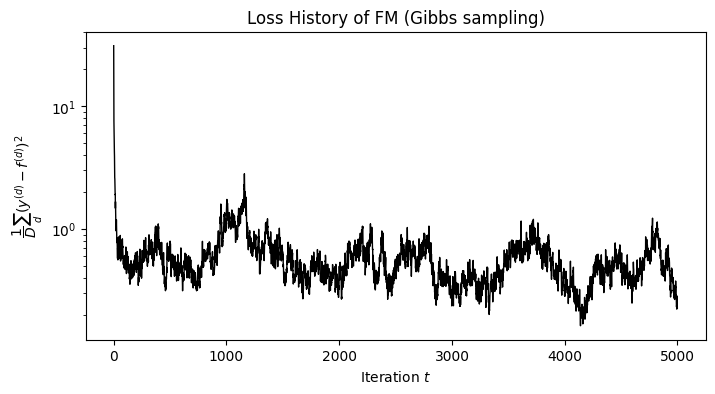

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# plt.scatter(range(len(loss_hist))[::100], loss_hist[::100], s=50, marker='o', color='none', edgecolors='black')
plt.plot(loss_hist, color='black', linewidth=1)
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.title('Loss History of FM (Gibbs sampling)')
plt.show()

The use of Gibbs sampling for learning has the advantage of swift convergence and automatic hyperparameter tuning capability.

Let us compare this with ALS.

In [10]:
# ALS version

Main.eval("""
    function sample_param_lstsq(
        x_theta::Array{Float64},
        y_theta::Array{Float64},
        lamb::Float64=1e-8
    ) :: Float64
        return sum(x_theta .* y_theta) / (sum(x_theta .^ 2) + lamb)
    end

    function train_fm_als(
        init_params::Dict{Any, Any},
        x_data::Array{Float64},
        y_data::Array{Float64, 1},
        f_init::Array{Float64, 1},
        num_iter::Int,
        show_progress::Bool=false
    ) :: Tuple{Dict{Any, Any}, Array{Float64}}
        # get indices
        N = size(x_data, 2)
        K = size(init_params["v"], 2)

        # get initial parameter
        params = init_params

        # precalculate
        f = f_init
        q = calc_q_init(x_data, params["v"])

        # main loop
        loss_hist = Float64[]
        for iter in 1:num_iter
            # sample b
            x_b, y_b = calc_xy_b(f, params["b"], x_data, y_data)
            b_new    = sample_param_lstsq(x_b, y_b)
            f        = f + calc_df(x_b, b_new, params["b"])
            params["b"] = b_new

            # sample w
            for i in 1:N
                x_w, y_w = calc_xy_w(f, params["w"], x_data, y_data, i)
                w_i_new  = sample_param_lstsq(x_w, y_w)
                f        = f + calc_df(x_w, w_i_new, params["w"][i])
                params["w"][i] = w_i_new

                # sample v
                for k in 1:K
                    x_v, y_v = calc_xy_v(f, q, params["v"], x_data, y_data, i, k)
                    v_ik_new = sample_param_lstsq(x_v, y_v)
                    f        = f      + calc_df(x_v, v_ik_new, params["v"][i, k])
                    q[:,k]   = q[:,k] + calc_dq(i, x_data, v_ik_new, params["v"][i, k])
                    params["v"][i, k] = v_ik_new
                end
            end

            if show_progress && (iter % 100 == 0)
                println("iter: $iter, loss: $(sum((y_data - f) .^ 2) / N)")
            end

            push!(loss_hist, sum((y_data - f) .^ 2) / N)
        end

        return params, loss_hist
    end
""")

<PyCall.jlwrap train_fm_als>

In [11]:
_, loss_hist_als = Main.train_fm_als(
    model_params,
    x_data.astype(float),
    y_data,
    fm.predict(x_data),
    2500,
)

_, loss_hist_gibbs = Main.train_fm_gibbs(
    model_params,
    latent_params,
    fixed_params,
    x_data.astype(float),
    y_data,
    fm.predict(x_data),
    2500,
)

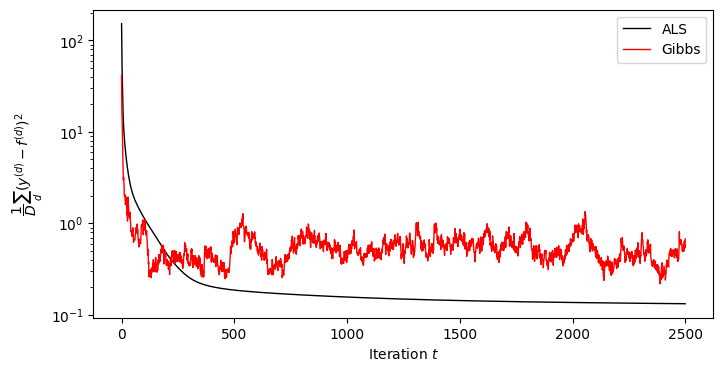

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(loss_hist_als, color='black', linewidth=1, label='ALS')
plt.plot(loss_hist_gibbs, color='red', linewidth=1, label='Gibbs')
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.legend()
plt.show()